# Introduction to Band Ratios & Spectral Features

The BandRatios project explore properties of band ratio measures.

Band ratio measures are an analysis measure in which the ratio of power between defined frequency bands is calculated. 

By 'spectral features' we mean features we can measure from the power spectra, such as periodic components, or oscillations, that we can describe with their center frequency, power and bandwidth, and aperiodic component, which we can describe with their exponent and offset value. These parameters will be further explored and explained later on. 

In this introductory notebook, we walk through how band ratio measures and spectral features are calculated.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')

from fooof import FOOOF
from fooof.sim import gen_power_spectrum
from fooof.analysis import get_band_peak_fm
from fooof.plts import plot_spectrum, plot_spectrum_shading

In [2]:
# Import custom project code
import sys
sys.path.append('../bratios')
from ratios import *
from paths import FIGS_PATHS as fp
from paths import DATA_PATHS as dp

In [3]:
# Settings
SAVE_FIG = True

## What is a Band Ratio

This project explores frequency band ratios, a metric used in spectral analysis since at least the 1960's to characterize cognitive functions such as vigilance, aging, memory among other. In clinical work, band ratios have also been used as a biomarker for diagnosing and monitoring of ADHD, diseases of consciousness, and nervous system disorders such as Parkinson's disease.

Given a power spectrum, a band ratio is the ratio of average power within a band between two frequency ranges. 

Typically, band ratio measures are calculated as:

$ \frac{avg(low\ band\ power)}{avg(high\ band\ power} $

The following cell generates a power spectrum and highlights the frequency ranges used to calculate a theta/beta band ratio.

In [4]:
# Settings
theta_band = [4, 8]
beta_band = [20, 30]
freq_range = [1, 35]

# Define default simulation values
ap_def = [0, 1]
theta_def = [6, 0.25, 1]
alpha_def = [10, 0.4, 0.75]
beta_def  = [25, 0.2, 1.5]

In [5]:
# Plot Settings
line_color = 'black'
shade_colors = ['#057D2E', '#0365C0']

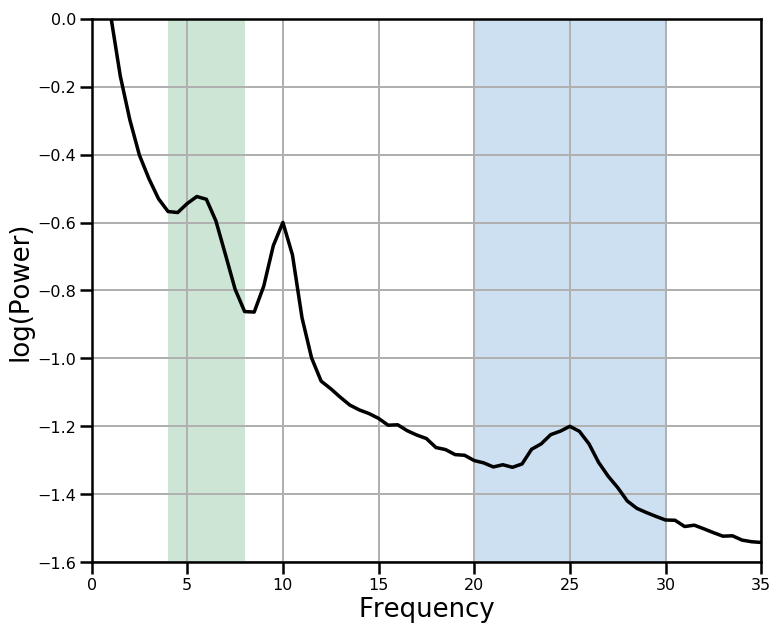

In [6]:
# Generate a simulated power spectrum
fs, ps = gen_power_spectrum(freq_range, ap_def,
                            [theta_def, alpha_def, beta_def])

# Plot and save out our shaded power spectrum plot
plot_spectrum_shading(fs, ps, [theta_band, beta_band],
                      color=line_color, shade_colors=shade_colors,
                      log_powers=True, linewidth=3.5)

# Plot aesthetics
ax = plt.gca()
for it in [ax.xaxis.label, ax.yaxis.label]:
    it.set_fontsize(26)
ax.set_xlim([0, 35])
ax.set_ylim([-1.6, 0])

if SAVE_FIG: plt.savefig(fp.make_file_path(fp.demo, 'Ratio-example', 'pdf'))

# Calculate theta/beta ratios 

### Average Power Ratio

The most canonical way of calculating band ratios is to take average power in the low-band and divide it by the average power from the high-band. 

Average power is calculated as the sum of all discrete power values divided by number on power values in that band.

In [7]:
ratio = calc_band_ratio(fs, ps, theta_band, beta_band)
print('Theta-beta ratio is: {:1.4f}'.format(ratio))

Theta-beta ratio is: 4.9835


And there you have it - our first computed frequency band ratio!

# The FOOOF Model

To compare to band ratios, and to measure other spectral features from power spectra, to compare to ratio measures, we will use the [FOOOF](https://github.com/fooof-tools/fooof) library. 

Briefly, the FOOOF algorithm parameterizes neural power spectra, measuring both periodic (oscillatory) and aperiodic features. 

Each identified oscillation is parameterized as a peak, fit as a gaussian, which provides us with a measures of the center frequency, power and bandwidth of that oscillations. 

The aperiodic component is measured by a function of the form $ 1/f^\chi $, in which this $ \chi $ value is referred to as the aperiodic exponent. 

This exponent is equivalent the the negative slope of the power spectrum, when plotted in log-log.  

More details on FOOOF can be found in the associated [paper](https://doi.org/10.1101/299859) and/or on the documentation [site](https://fooof-tools.github.io/fooof/).

In [8]:
# Load power spectra from an example subject
psd = np.load(dp.make_file_path(dp.eeg_psds, 'A00051886_ec_avg_psds', 'npz'))

# Unpack the loaded power spectra, and select a spectrum to fit
freqs = psd['arr_0']
powers = psd['arr_1'][50]

In [9]:
# Initialize a FOOOF object
fm = FOOOF(verbose=False)

# Fit the FOOOF model
fm.fit(freqs, powers)

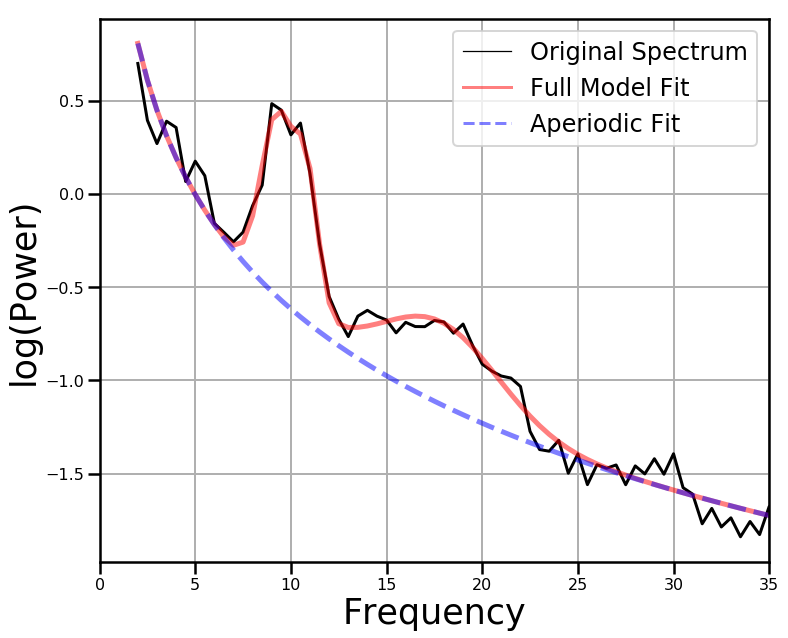

In [10]:
# Plot the power spectrum, with the FOOOF model
fm.plot()

# Plot aesthetic updates
ax = plt.gca()
ax.set_ylabel('log(Power)', {'fontsize':35})
ax.set_xlabel('Frequency', {'fontsize':35})
plt.legend(prop={'size': 24})
for line, width in zip(ax.get_lines(), [3, 5, 5]):
    line.set_linewidth(width)
ax.set_xlim([0, 35]);

# Save out the FOOOF figure
if SAVE_FIG: plt.savefig(fp.make_file_path(fp.demo, 'FOOOF-example', 'pdf'))

In the plot above, the the FOOOF model fit, in red, is plotted over the original data.

The blue dashed line is the fit of the aperiodic component of the data. The aperiodic exponent describes the steepness of this line.

For all future notebooks, the aperiodic exponent reflects values that are simulated and/or measured with the FOOOF model, reflecting the blue line. 

Periodic spectral features are simulation values and/or model fit values from the FOOOF model that measure oscillatory peaks over and above the blue dashed line. 

#### Helper settings & functions for the next section

In [11]:
# Settings
f_theta = 6
f_beta = 25

In [12]:
# Functions
def style_plot(ax):
    """Helper function to style plots."""
    
    ax.get_legend().remove()
    ax.grid(False)
    for line in ax.get_lines():
        line.set_linewidth(3.5)
    ax.set_xticks([])
    ax.set_yticks([])
    
def add_lines(ax, fs, ps, f_val):
    """Helper function to add vertical lines to power spectra plots."""
    
    y_lims = ax.get_ylim()
    ax.plot([f_val, f_val], [y_lims[0], np.log10(ps[fs==f_val][0])],
            'g--', markersize=12, alpha=0.75)
    ax.set_ylim(y_lims)

### Comparing Ratios With and Without Periodic Activity

In the next section, we will explore power spectra with and without periodic activity within specified bands. 

We will use simulations to explore how ratio measures relate to the presence or absence or periodic activity, and how this relates to the analyses we will be performing, comparing ratio measures to spectral features.

In [13]:
# Generate simulated power spectrum, with and without a theta & beta oscillations
fs, ps0 = gen_power_spectrum(freq_range, ap_def,
                             [theta_def, alpha_def, beta_def])
fs, ps1 = gen_power_spectrum(freq_range, ap_def,
                             [alpha_def, beta_def])
fs, ps2 = gen_power_spectrum(freq_range, ap_def,
                             [theta_def, alpha_def])
fs, ps3 = gen_power_spectrum(freq_range, ap_def,
                             [alpha_def])

In [14]:
# Initialize some FOOOF models
fm0 = FOOOF(verbose=False)
fm1 = FOOOF(verbose=False)
fm2 = FOOOF(verbose=False)
fm3 = FOOOF(verbose=False)

In [15]:
# Fit FOOOF models
fm0.fit(fs, ps0)
fm1.fit(fs, ps1)
fm2.fit(fs, ps2)
fm3.fit(fs, ps3)

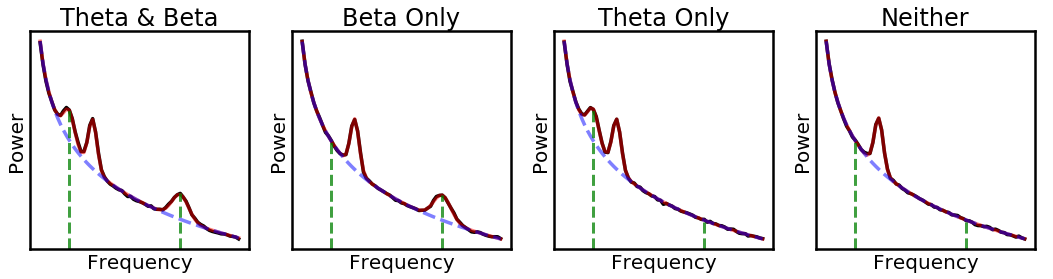

In [16]:
# Create a plot with the spectra
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
titles = ['Theta & Beta', 'Beta Only', 'Theta Only', 'Neither']

for cur_fm, cur_ps, cur_title, cur_ax in zip(
    [fm0, fm1, fm2, fm3], [ps0, ps1, ps2, ps3], titles, axes):
    
    # Create the 
    cur_fm.plot(ax=cur_ax)
    cur_ax.set_title(cur_title)
    style_plot(cur_ax)
    add_lines(cur_ax, fs, cur_ps, f_theta)
    add_lines(cur_ax, fs, cur_ps, f_beta)

# Save out the FOOOF figure
if SAVE_FIG: plt.savefig(fp.make_file_path(fp.demo, 'PeakComparisons', 'pdf'))

Note that in the plots above, we have plotted the power spectra, with the aperiodic component parameterized in blue. 

The potential location of peaks is indicated in green.

Keep in mind that under the FOOOF model idea, there is only evidence for an oscillation if there is band specific power over and above the aperiodic activity.

In the first power spectrum, for example, we see clear peaks in both theta and beta. However, in subsequent power spectra, we have created spectra without theta, without theta, and without either (or, alternatively put, spectra in which the FOOOF model would say there is no evidence of peaks in these bands. 

We can actually check our model parameterizations, to see if and when theta and beta peaks were detected, over and above the aperiodic, was measured. 

In [17]:
# Check if there are extracted thetas in the model parameterizations
print('Theta & Beta: \t', get_band_peak_fm(fm0, theta_band))
print('Beta Only: \t', get_band_peak_fm(fm1, theta_band))
print('Theta Only: \t', get_band_peak_fm(fm2, theta_band))
print('Neither: \t', get_band_peak_fm(fm3, theta_band))

Theta & Beta: 	 [5.97251532 0.2364619  1.87407314]
Beta Only: 	 [nan nan nan]
Theta Only: 	 [5.99341473 0.24864455 1.94138615]
Neither: 	 [nan nan nan]


Now, just because there is no evidence of, for example, theta activity specifically, does not mean there is no power in the 4-8 Hz range. 

We can see this in the power spectra, as the aperiodic component also contributes power across all frequencies. 

This means that, due to the way that band ratio measures are calculated, the theta-beta ratio in power spectra without any actual theta activity (or beta) will still measure a value. 

In [18]:
print('Theta / Beta Ratio  of  Theta & Beta: \t{:1.4f}'.format(
    calc_band_ratio(fm0.freqs, fm0.power_spectrum, theta_band, beta_band)))
print('Theta / Beta Ratio  of  Beta Only: \t{:1.4f}'.format(
    calc_band_ratio(fm1.freqs, fm1.power_spectrum, theta_band, beta_band)))
print('Theta / Beta Ratio  of  Theta Only: \t{:1.4f}'.format(
    calc_band_ratio(fm2.freqs, fm2.power_spectrum, theta_band, beta_band)))
print('Theta / Beta Ratio  of  Neither: \t{:1.4f}'.format(
    calc_band_ratio(fm3.freqs, fm3.power_spectrum, theta_band, beta_band)))

Theta / Beta Ratio  of  Theta & Beta: 	0.4779
Theta / Beta Ratio  of  Beta Only: 	0.5790
Theta / Beta Ratio  of  Theta Only: 	0.4524
Theta / Beta Ratio  of  Neither: 	0.5499


As we can see above, as compared to the 'Theta & Beta' PSD, the theta / beta ratio of the 'Beta Only' PSD is higher (which we might interpret as reflecting less theta  or more beta activity), and the theta / beta ratio of the 'Theta Only' PSD is lower (which we might interpret as reflecting more theta or less beta activity).

However, we know that these are not really the best interpretations, in so far as we would like to say that these differences reflect the lack of theta and beta, and not merely a change in their power. 

In the extreme case, with no theta or beta peaks at all, we still measure a (quite high) value for the theta / beta ratio, though in this case it entirely reflects aperiodic activity. It is important to note that the measure is not zero (or undefined) as we might expect or want in cases in which there is no oscillatory activity, over and above the aperiodic component.

### Summary

In this notebook, we have explored band ratio measures, and spectral features, using the FOOOF model.

One thing to keep in mind, for the upcoming analyses in this project is that when we compare a ratio value to periodic power, we do so to the isolated periodic power - periodic power over and above the aperiodic power - and we can only calculate this when there is actually power over and above the aperiodic component.

That is to say, revisiting the plots above, the periodic activity we are interested in is not the green line, which is total power, but rather is section of the green line above the blue line (the aperiodic adjusted power measured by FOOOF). This means that to compare ratio values to periodic power, we can only calculate this, and only do so, when we measure periodic power within the specified band.